In [4]:
import mysql.connector
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import calendar
import datetime
from datetime import timedelta
import random
import sys, os
sys.path.append(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\CodeAnalyses\Comportement\BehavioralPerformances')
from Functions.ExtractFromDB import *
ColourValues = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9','C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'];

In [5]:
class MazeData:
    
    def __init__(self, trainingset):
        
        self.cnx = mysql.connector.connect(host="127.0.0.1",user="Tim",passwd="Turion162!",db="maze")
           
        cursor = self.cnx.cursor()
        query = ("""
            SELECT training_set_name, training_set_description FROM maze.training_set_def as ms
            where training_set_id = %s""")
        Add= (trainingset,)
        cursor.execute(query, Add)
        result=cursor.fetchall()
        cursor.close()
        Mlist = [y for x in result for y in x]
        print("Select: {} : {} : {}".format(trainingset,Mlist[0],Mlist[1]))
        
        self.TrSetNnb=trainingset
        self.TrSetName=Mlist[0]

        cursor = self.cnx.cursor()
        query = ("""
            SELECT distinct(mouse_number) FROM maze.mouses_sessions as ms
            INNER JOIN mouses as mo ON mo.mouses_id = ms.mouses_id
            where training_set_id = %s
            order by mouse_number""")
        Add= (trainingset,)
        cursor.execute(query, Add)
        result=cursor.fetchall()
        cursor.close()
        self.MouseList = [y for x in result for y in x]
        
        cursor = self.cnx.cursor()
        query = ("""
                SELECT mouse_number, sd.session_id, count(id_session_detail) FROM session_detail as sd
                INNER JOIN mouses_sessions as ms ON ms.session_id = sd.session_id
                INNER JOIN mouses as mo ON mo.mouses_id = ms.mouses_id
                WHERE ms.training_set_id = %s AND event_value = 255
                GROUP BY sd.session_id
                  """)
        Add= (trainingset,)
        cursor.execute(query, Add)
        result=cursor.fetchall()
        cursor.close()
        self.IndexStorage = np.asarray(result)
    
    def ExtractSequences(self,arglist):
        query = ("""
            SELECT event_value FROM session_detail sd
            WHERE session_id = %s AND event_value IN(""")
        i = 0
        for I in arglist :
            if i >= len(arglist)-1:
                query = query + str(I)
            else:
                query = query + str(I) + ", "  
            i = i+1   
        query = query + ") ORDER BY timestamp"
            
        #temp = np.empty([0,1])
        self.SessSeq_storage = {}
        for J in self.IndexStorage:
                    
            cursor = self.cnx.cursor()
            Add= (str(J[1]),)
            cursor.execute(query, Add)
            result=cursor.fetchall()
            cursor.close()
            buffR = [y for x in result for y in x]
            self.SessSeq_storage[J[1]] = buffR
        
        self.SessSeqRewd_storage = {}
        for J in self.IndexStorage:
            seqTemp = self.SessSeq_storage.get(J[1])
            ListTheorique=[]
            for i in seqTemp:
                if i == 3 or i == -4 or i == 1 or i == -2:
                    ListTheorique.append(1)# 1= Recomprense à Droite
                elif i == 4 or i == -3 or i == 2 or i == -1:
                    ListTheorique.append(2)# 2= Recomprense à Gauche
            self.SessSeqRewd_storage[J[1]]=ListTheorique
            
        self.SessSeqMouse_storage = {}
        for J in self.IndexStorage:
            seqTemp = self.SessSeq_storage.get(J[1])
            ListReele=[]
            for i in seqTemp:
                if i == 3 or i == -3 or i == 1 or i == -1:
                    ListReele.append(1)# 1= Souris à Droite
                elif i == 4 or i == -4 or i == 2 or i == -2:
                    ListReele.append(2)# 2= Souris à Gauche
            self.SessSeqMouse_storage[J[1]]=ListReele
                
    def CalulateProbas(self,dicto) :
        self.Probas_storage = {}
        for J in self.IndexStorage :
            seqTemp = dicto.get(J[1])
            Results = np.zeros([1,2])
            for U in range(len(seqTemp)):
                if U > 0 :
                    if seqTemp[U] == seqTemp[U-1]:
                        Results[0,1] = Results[0,1] + 1
                    elif seqTemp[U] != seqTemp[U-1]:
                        Results[0,0] = Results[0,0] + 1 #Number of times the mouse turns the opposite side after a trial end
            Results=np.concatenate((Results,np.array([[J[2]]])),axis = 1)
            Results=np.concatenate((Results,np.array([[ Results[0,0]/(Results[0,1]+Results[0,0])  ]])),axis = 1)
            #Probas storage [0,3] contains the probability to turn the oposite side after a trial end
            self.Probas_storage[J[1]] = Results
                
            
            

Select: 26 : Phase3_unimodal_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles


C:\Users\Timothe\Anaconda3\envs\ArduinoComs\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars


Select: 26 : Phase3_unimodal_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles


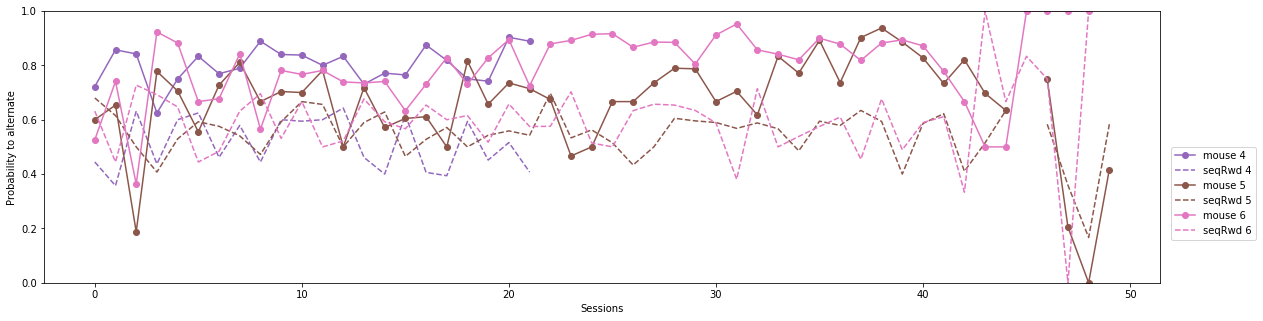

Select: 27 : Phase3_bimodal_a_b3 : Phase 3 bimodal A : choix droite ou gauche selon le stimulus présenté. Les stimulus sont éclairés
Select: 27 : Phase3_bimodal_a_b3 : Phase 3 bimodal A : choix droite ou gauche selon le stimulus présenté. Les stimulus sont éclairés


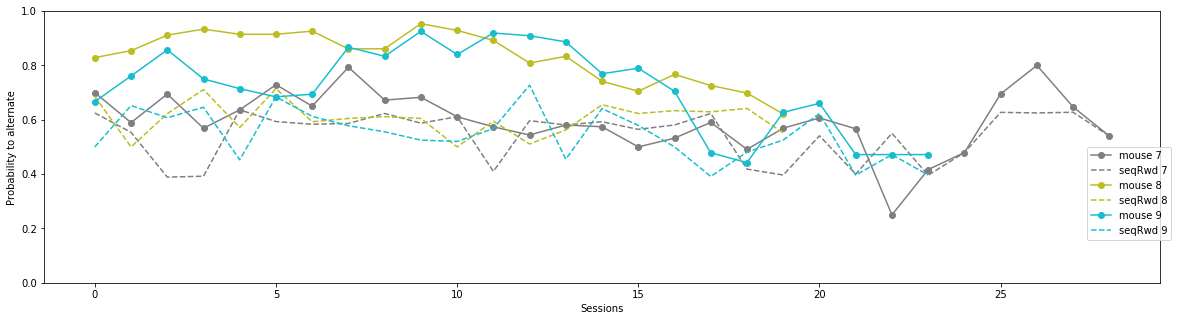

Select: 28 : Phase3_bimodal_b_b3 : Phase 3 bimodal B: choix droite ou gauche selon le stimulus présenté. Les stimulus sont très peu éclairés
Select: 28 : Phase3_bimodal_b_b3 : Phase 3 bimodal B: choix droite ou gauche selon le stimulus présenté. Les stimulus sont très peu éclairés


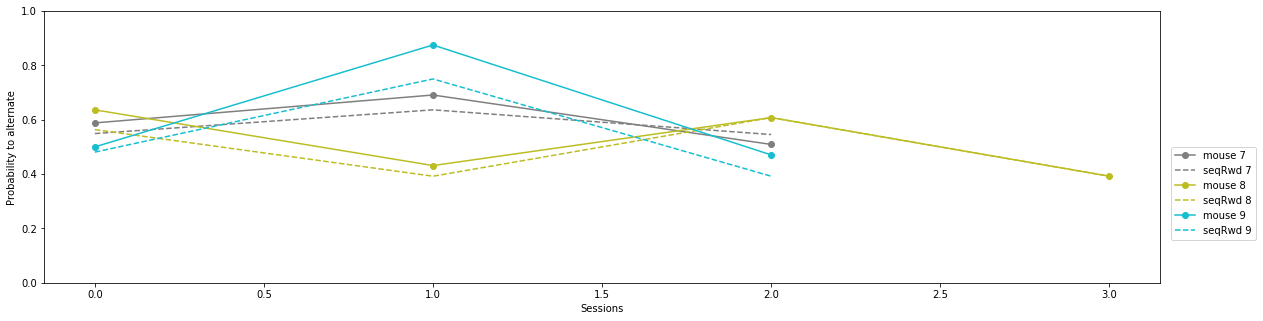

Select: 30 : Phase3_unimodal2_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles
Select: 30 : Phase3_unimodal2_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles


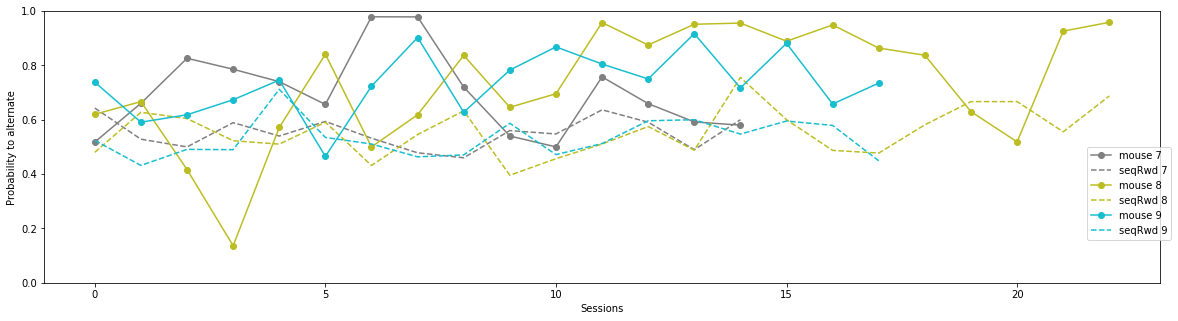

Select: 32 : PhaseX_LedSide_b2 : Phase annexe : souris n'utilisant pas les timuli tactile mais plutôt la position indiquée par les leds proches des lickports pour tourner
Select: 32 : PhaseX_LedSide_b2 : Phase annexe : souris n'utilisant pas les timuli tactile mais plutôt la position indiquée par les leds proches des lickports pour tourner


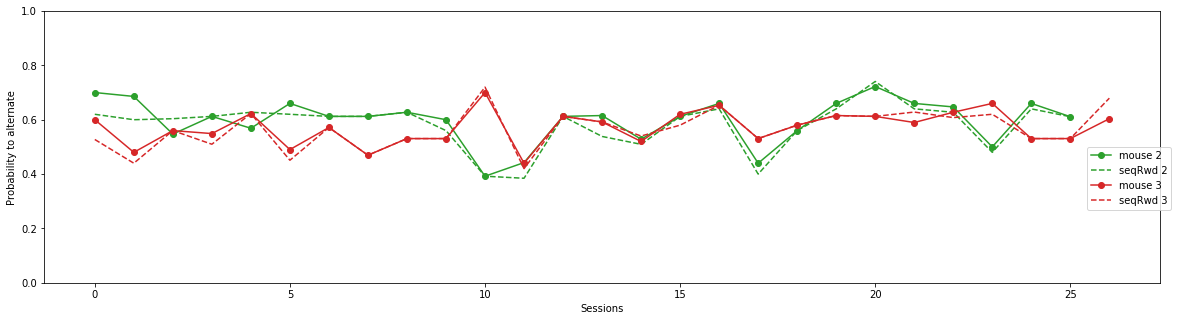

In [40]:
for I in 26,27,28,30,32:
    MS=MazeData(I)
    MS.ExtractSequences([3,4,-3,-4])
    MS.CalulateProbas(MS.SessSeqMouse_storage)
    TS=MazeData(I)
    TS.ExtractSequences([3,4,-3,-4])
    TS.CalulateProbas(MS.SessSeqRewd_storage)
    fig=plt.figure(figsize=(20, 5))
    for U in MS.MouseList:
        PlotList=[]
        
        for J in MS.IndexStorage:
            if J[0]==U :
                PlotList.append(MS.Probas_storage.get(J[1])[0,3])
        PlotList2=[]
        for J in TS.IndexStorage:
            if J[0]==U :
                PlotList2.append(TS.Probas_storage.get(J[1])[0,3])
        plt.plot(PlotList,'-o',color = ColourValues[U],label="mouse {}".format(U))
        plt.plot(PlotList2,'--',color = ColourValues[U],label="seqRwd {}".format(U))
    
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc=0, borderaxespad=0)
    plt.ylim([0,1])
    plt.ylabel("Probability to alternate")
    plt.xlabel("Sessions")
    plt.savefig(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\Resultats\Comportement\Plots\GrpAvrilMai19\ProbasTurns\CourbesProbasTurns_{}.png'.format(MS.TrSetName), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=True)
    plt.show()

In [54]:
print(T)
print(np.shape(T))
T=np.append(T,np.array([[1]]),axis=0)
T=np.append(T,np.array([[1]]),axis=0)
U=np.array([[1,2],[3,4]])
List = np.array([[1,2],[3,4]])
U[1,1]=List

NameError: name 'T' is not defined

In [69]:
#np.zeros([0,1])
Results = np.zeros([1,2])
print(np.shape(np.array([[3]])))
np.concatenate((Results,np.array([[3]])),axis = 1)

(1, 1)


ValueError: all the input array dimensions except for the concatenation axis must match exactly